In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

bc_data = datasets.load_breast_cancer()
df = pd.DataFrame(data= np.c_[bc_data['data'], bc_data['target']],
                     columns=list(bc_data['feature_names']) + ['target'])

X = df.values[:, :-1]
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


pipeline = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA()),
    ('lr', LogisticRegression())])
pipeline.fit(X_train, y_train)

print('Test acc: {}'.format(pipeline.score(X_test, y_test)))


Test acc: 0.982456140351


In [7]:
kfold = StratifiedKFold(n_splits=10, random_state=1)

for k, (train, test) in enumerate(kfold.split(X_train, y_train)):
    pipeline.fit(X_train[train], y_train[train])
    print('Fold {}, class dist {}, score {}'.format(k, np.bincount(y_train[train]), 
                                                    pipeline.score(X_test[test], y_test[test])))
    

In [2]:
scores = cross_val_score(estimator=pipeline, X=X_train, y=y_train, cv=10, n_jobs=1)
print(scores)

[ 0.93478261  0.97826087  0.95652174  0.97826087  0.97826087  1.          1.
  0.97777778  0.97777778  0.97777778]


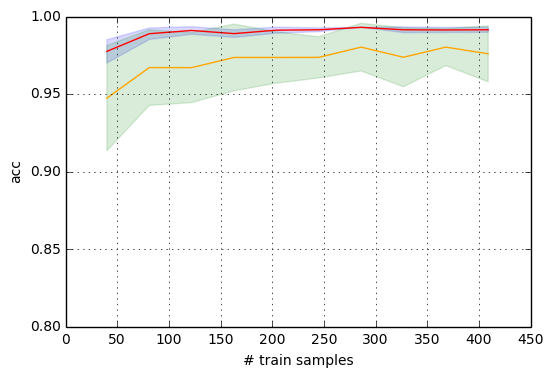

In [6]:
import matplotlib.pyplot as plt 
from sklearn.learning_curve import learning_curve

pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', random_state=0))
])

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, X=X_train, y=y_train, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='red', label='training acc')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='orange', label='validation acc')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

plt.grid()
plt.xlabel('# train samples')
plt.ylabel('acc')
plt.ylim([0.8, 1.0])
plt.show()